In [46]:
import pandas as pd
import numpy as np
grid = pd.read_pickle("outputs_in_instab_strip.pkl")

# then we have to first create the X and y matrices.

l_values = [0, 1, 2] 
l_columns = {l: [col for col in grid.columns if col.endswith(f"_l_{l}")] for l in l_values}

X_frequencies = np.hstack([grid[l_columns[l]].values for l in l_values])  
delta_nu_values = grid["delta_nu"].values[:, np.newaxis] 
mod_frequencies = X_frequencies % delta_nu_values 

X = np.stack((X_frequencies, mod_frequencies), axis=-1)
y = np.hstack([np.full_like(grid[l_columns[l]].values, l) for l in l_values])  

print(f"X-matrix shape: {X.shape}")
print(f"y-matrix shape: {y.shape}") 

from sklearn.model_selection import train_test_split
import torch

# Convert data to tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)  # Assuming y contains class labels

# Split the data (80% train, 10% val, 10% test)
X_train, X_temp, y_train, y_temp = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Print shape
print(f"Train: {X_train.shape}, Validation: {X_val.shape}, Test: {X_test.shape}")

size = X_train.shape[0]
inpt = X_train[:size]
print(inpt.shape)

X-matrix shape: (153314, 30, 2)
y-matrix shape: (153314, 30)
Train: torch.Size([122651, 30, 2]), Validation: torch.Size([15331, 30, 2]), Test: torch.Size([15332, 30, 2])
torch.Size([122651, 30, 2])


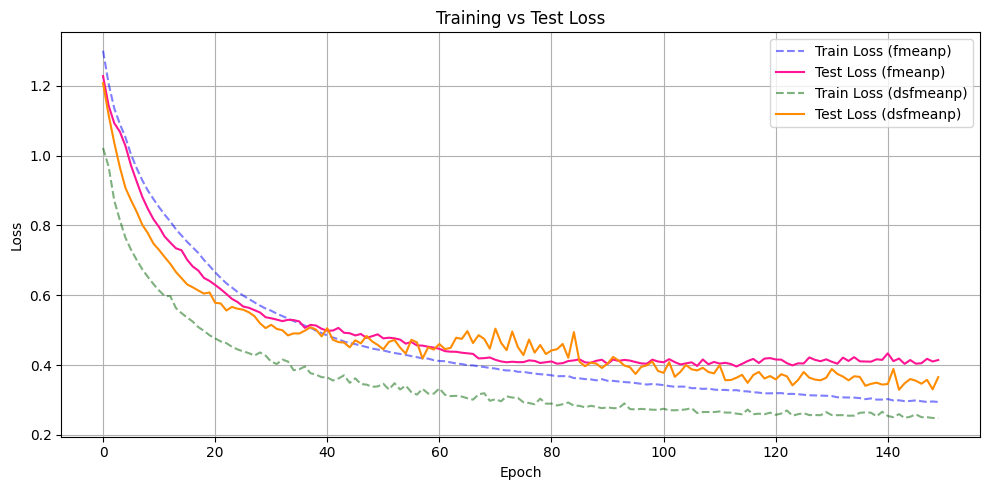

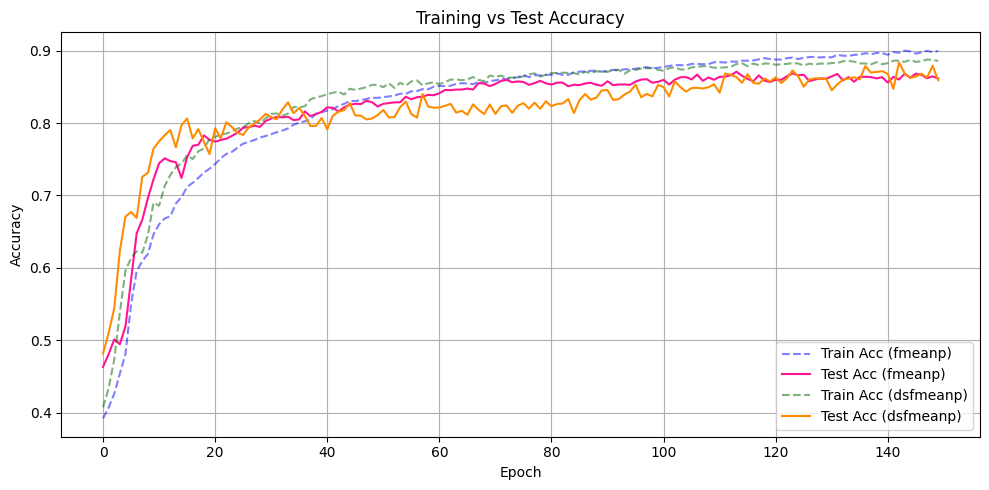

Final Test Accuracy (fmeanp): 0.8613031567962431
Final Test Accuracy (dsfmeanp): 0.8591529698234629


In [47]:
import pickle
import matplotlib.pyplot as plt

def load_pickle(filename):
    with open(filename, "rb") as f:
        return pickle.load(f)

# --- Load loss histories ---
train_loss_fmeanp = load_pickle("train_history_fmeanp.pkl")
test_loss_fmeanp  = load_pickle("test_history_fmeanp.pkl")
train_loss_dsfmeanp = load_pickle("train_history_dsfmeanp.pkl")
test_loss_dsfmeanp  = load_pickle("test_history_dsfmeanp.pkl")

# --- Load accuracy histories ---
train_acc_fmeanp = load_pickle("train_acc_history_fmeanp.pkl")
test_acc_fmeanp  = load_pickle("test_acc_history_fmeanp.pkl")
train_acc_dsfmeanp = load_pickle("train_acc_history_dsfmeanp.pkl")
test_acc_dsfmeanp  = load_pickle("test_acc_history_dsfmeanp.pkl")

# --- Load final test accuracies ---
test_accuracy_fmeanp  = load_pickle("test_accuracy_fmeanp.pkl")
test_accuracy_dsfmeanp = load_pickle("test_accuracy_dsfmeanp.pkl")

# --- Plot Loss ---
plt.figure(figsize=(10, 5))
plt.plot(train_loss_fmeanp, label="Train Loss (fmeanp)", color="blue", linestyle="--", alpha=0.5)
plt.plot(test_loss_fmeanp,  label="Test Loss (fmeanp)", color="deeppink")
plt.plot(train_loss_dsfmeanp, label="Train Loss (dsfmeanp)", color="darkgreen", linestyle="--", alpha=0.5)
plt.plot(test_loss_dsfmeanp,  label="Test Loss (dsfmeanp)", color="darkorange")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Test Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("loss_curves.png", dpi=150)
plt.show()

# --- Plot Accuracy ---
plt.figure(figsize=(10, 5))
plt.plot(train_acc_fmeanp, label="Train Acc (fmeanp)", color="blue", linestyle="--", alpha=0.5)
plt.plot(test_acc_fmeanp,  label="Test Acc (fmeanp)", color="deeppink")
plt.plot(train_acc_dsfmeanp, label="Train Acc (dsfmeanp)", color="darkgreen", linestyle="--", alpha=0.5)
plt.plot(test_acc_dsfmeanp,  label="Test Acc (dsfmeanp)", color="darkorange")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Test Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("accuracy_curves.png", dpi=300)
plt.show()

# --- Print summary ---
print("Final Test Accuracy (fmeanp):", test_accuracy_fmeanp)
print("Final Test Accuracy (dsfmeanp):", test_accuracy_dsfmeanp)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import random
import torch

# Config
REAL_CLASSES = [0, 1, 2]
FAKE_CLASS = 'fake'
color_map = {0: '#a5c19b', 1: '#6c4385', 2: '#e3a0c0', FAKE_CLASS: 'gold'}
marker_size = 70

num_models = X_test.shape[0]
num_points = X_test.shape[1]

# Pick a random model/sample
model_idx = random.randint(0, num_models - 1)
print(f"Selected model index: {model_idx}")

def prepare_plot_data(output_logits, y_test):
    # logits: [num_classes, num_points] tensor
    logits = output_logits[model_idx].detach().cpu().numpy() if torch.is_tensor(output_logits) else output_logits[model_idx]
    labels = y_test[model_idx]

    # Extract frequency mod Δν and power from X_test
    freqs = X_test[model_idx,:,1].numpy() if torch.is_tensor(X_test) else X_test[model_idx,:,1]
    powers = X_test[model_idx,:,0].numpy() if torch.is_tensor(X_test) else X_test[model_idx,:,0]

    # Mask invalid points
    valid_mask = labels != -1
    labels = labels[valid_mask]
    logits = logits[:, valid_mask]  # keep all classes
    freqs = freqs[valid_mask]
    powers = powers[valid_mask]

    # Convert logits to probabilities
    logits = logits - np.max(logits, axis=0, keepdims=True)
    probs = np.exp(logits)
    probs /= probs.sum(axis=0, keepdims=True)

    # Predictions
    preds = np.argmax(probs, axis=0)
    preds_display = np.array([p if p in REAL_CLASSES else FAKE_CLASS for p in preds], dtype=object)
    labels_display = np.array([l if l in REAL_CLASSES else FAKE_CLASS for l in labels], dtype=object)

    probs_true_label = np.array([probs[l,i] if l in REAL_CLASSES else 0.0 for i,l in enumerate(labels)])
    colors_true = [color_map[l] for l in labels_display]
    edge_colors_pred = [color_map[p] for p in preds_display]

    # Misclassified points
    wrong_mask = preds != labels
    wrong_freqs = freqs[wrong_mask]
    wrong_powers = powers[wrong_mask]
    wrong_edge_colors = np.array(edge_colors_pred)[wrong_mask]

    return freqs, powers, labels_display, preds_display, probs_true_label, colors_true, wrong_freqs, wrong_powers, wrong_edge_colors

# Prepare data for fmeanp and dsfmeanp
f_freqs, f_powers, f_labels_disp, f_preds_disp, f_probs_true, f_colors, f_wrong_freqs, f_wrong_powers, f_wrong_edges = prepare_plot_data(output_fmeanp, y_test_fmeanp)
d_freqs, d_powers, d_labels_disp, d_preds_disp, d_probs_true, d_colors, d_wrong_freqs, d_wrong_powers, d_wrong_edges = prepare_plot_data(output_dsfmeanp, y_test_dsfmeanp)

# Plot 2x2
fig, axs = plt.subplots(2,2, figsize=(14,12), dpi=300)

# Top row: Fmeanp
axs[0,0].scatter(f_freqs, f_powers, c=f_colors, edgecolors='black', linewidths=0.3, s=marker_size)
axs[0,0].set_title("Fmeanp — True Mode Labels")
axs[0,0].set_xlabel("ν mod Δν (d$^{-1}$)")
axs[0,0].set_ylabel("Frequency (d$^{-1}$)")

axs[0,1].scatter(f_freqs, f_powers, c=f_colors, alpha=np.clip(f_probs_true,0.3,1.0), edgecolors='black', linewidths=0.3, s=marker_size)
axs[0,1].scatter(f_wrong_freqs, f_wrong_powers, facecolors='none', edgecolors=f_wrong_edges, linewidths=2.0, s=marker_size+80)
for i in range(len(f_freqs)):
    axs[0,1].text(f_freqs[i], f_powers[i]+0.8, f"{f_probs_true[i]:.3f}", fontsize=8.5, ha='center', va='bottom', color='black')
axs[0,1].set_title("Fmeanp — Model Predictions")
axs[0,1].set_xlabel("ν mod Δν (d$^{-1}$)")
axs[0,1].set_ylabel("Frequency (d$^{-1}$)")

# Bottom row: DSFmeanp
axs[1,0].scatter(d_freqs, d_powers, c=d_colors, edgecolors='black', linewidths=0.3, s=marker_size)
axs[1,0].set_title("DSFmeanp — True Mode Labels")
axs[1,0].set_xlabel("ν mod Δν (d$^{-1}$)")
axs[1,0].set_ylabel("Frequency (d$^{-1}$)")

axs[1,1].scatter(d_freqs, d_powers, c=d_colors, alpha=np.clip(d_probs_true,0.3,1.0), edgecolors='black', linewidths=0.3, s=marker_size)
axs[1,1].scatter(d_wrong_freqs, d_wrong_powers, facecolors='none', edgecolors=d_wrong_edges, linewidths=2.0, s=marker_size+80)
for i in range(len(d_freqs)):
    axs[1,1].text(d_freqs[i], d_powers[i]+0.8, f"{d_probs_true[i]:.3f}", fontsize=8.5, ha='center', va='bottom', color='black')
axs[1,1].set_title("DSFmeanp — Model Predictions")
axs[1,1].set_xlabel("ν mod Δν (d$^{-1}$)")
axs[1,1].set_ylabel("Frequency (d$^{-1}$)")

# Legend
legend_elements = [
    mpatches.Patch(color=color_map[0], label='l=0'),
    mpatches.Patch(color=color_map[1], label='l=1'),
    mpatches.Patch(color=color_map[2], label='l=2'),
    mpatches.Patch(color=color_map[FAKE_CLASS], label='fake')
]
axs[0,0].legend(handles=legend_elements, title="l-mode", loc="upper right")
axs[1,0].legend(handles=legend_elements, title="l-mode", loc="upper right")

plt.tight_layout()
plt.show()

NameError: name 'X_test' is not defined

## Maybe also plot the fake frequencies that were injected? 
# doesn not work bc we didn't store fale freqs but still keeping this here

Selected model index: 12938


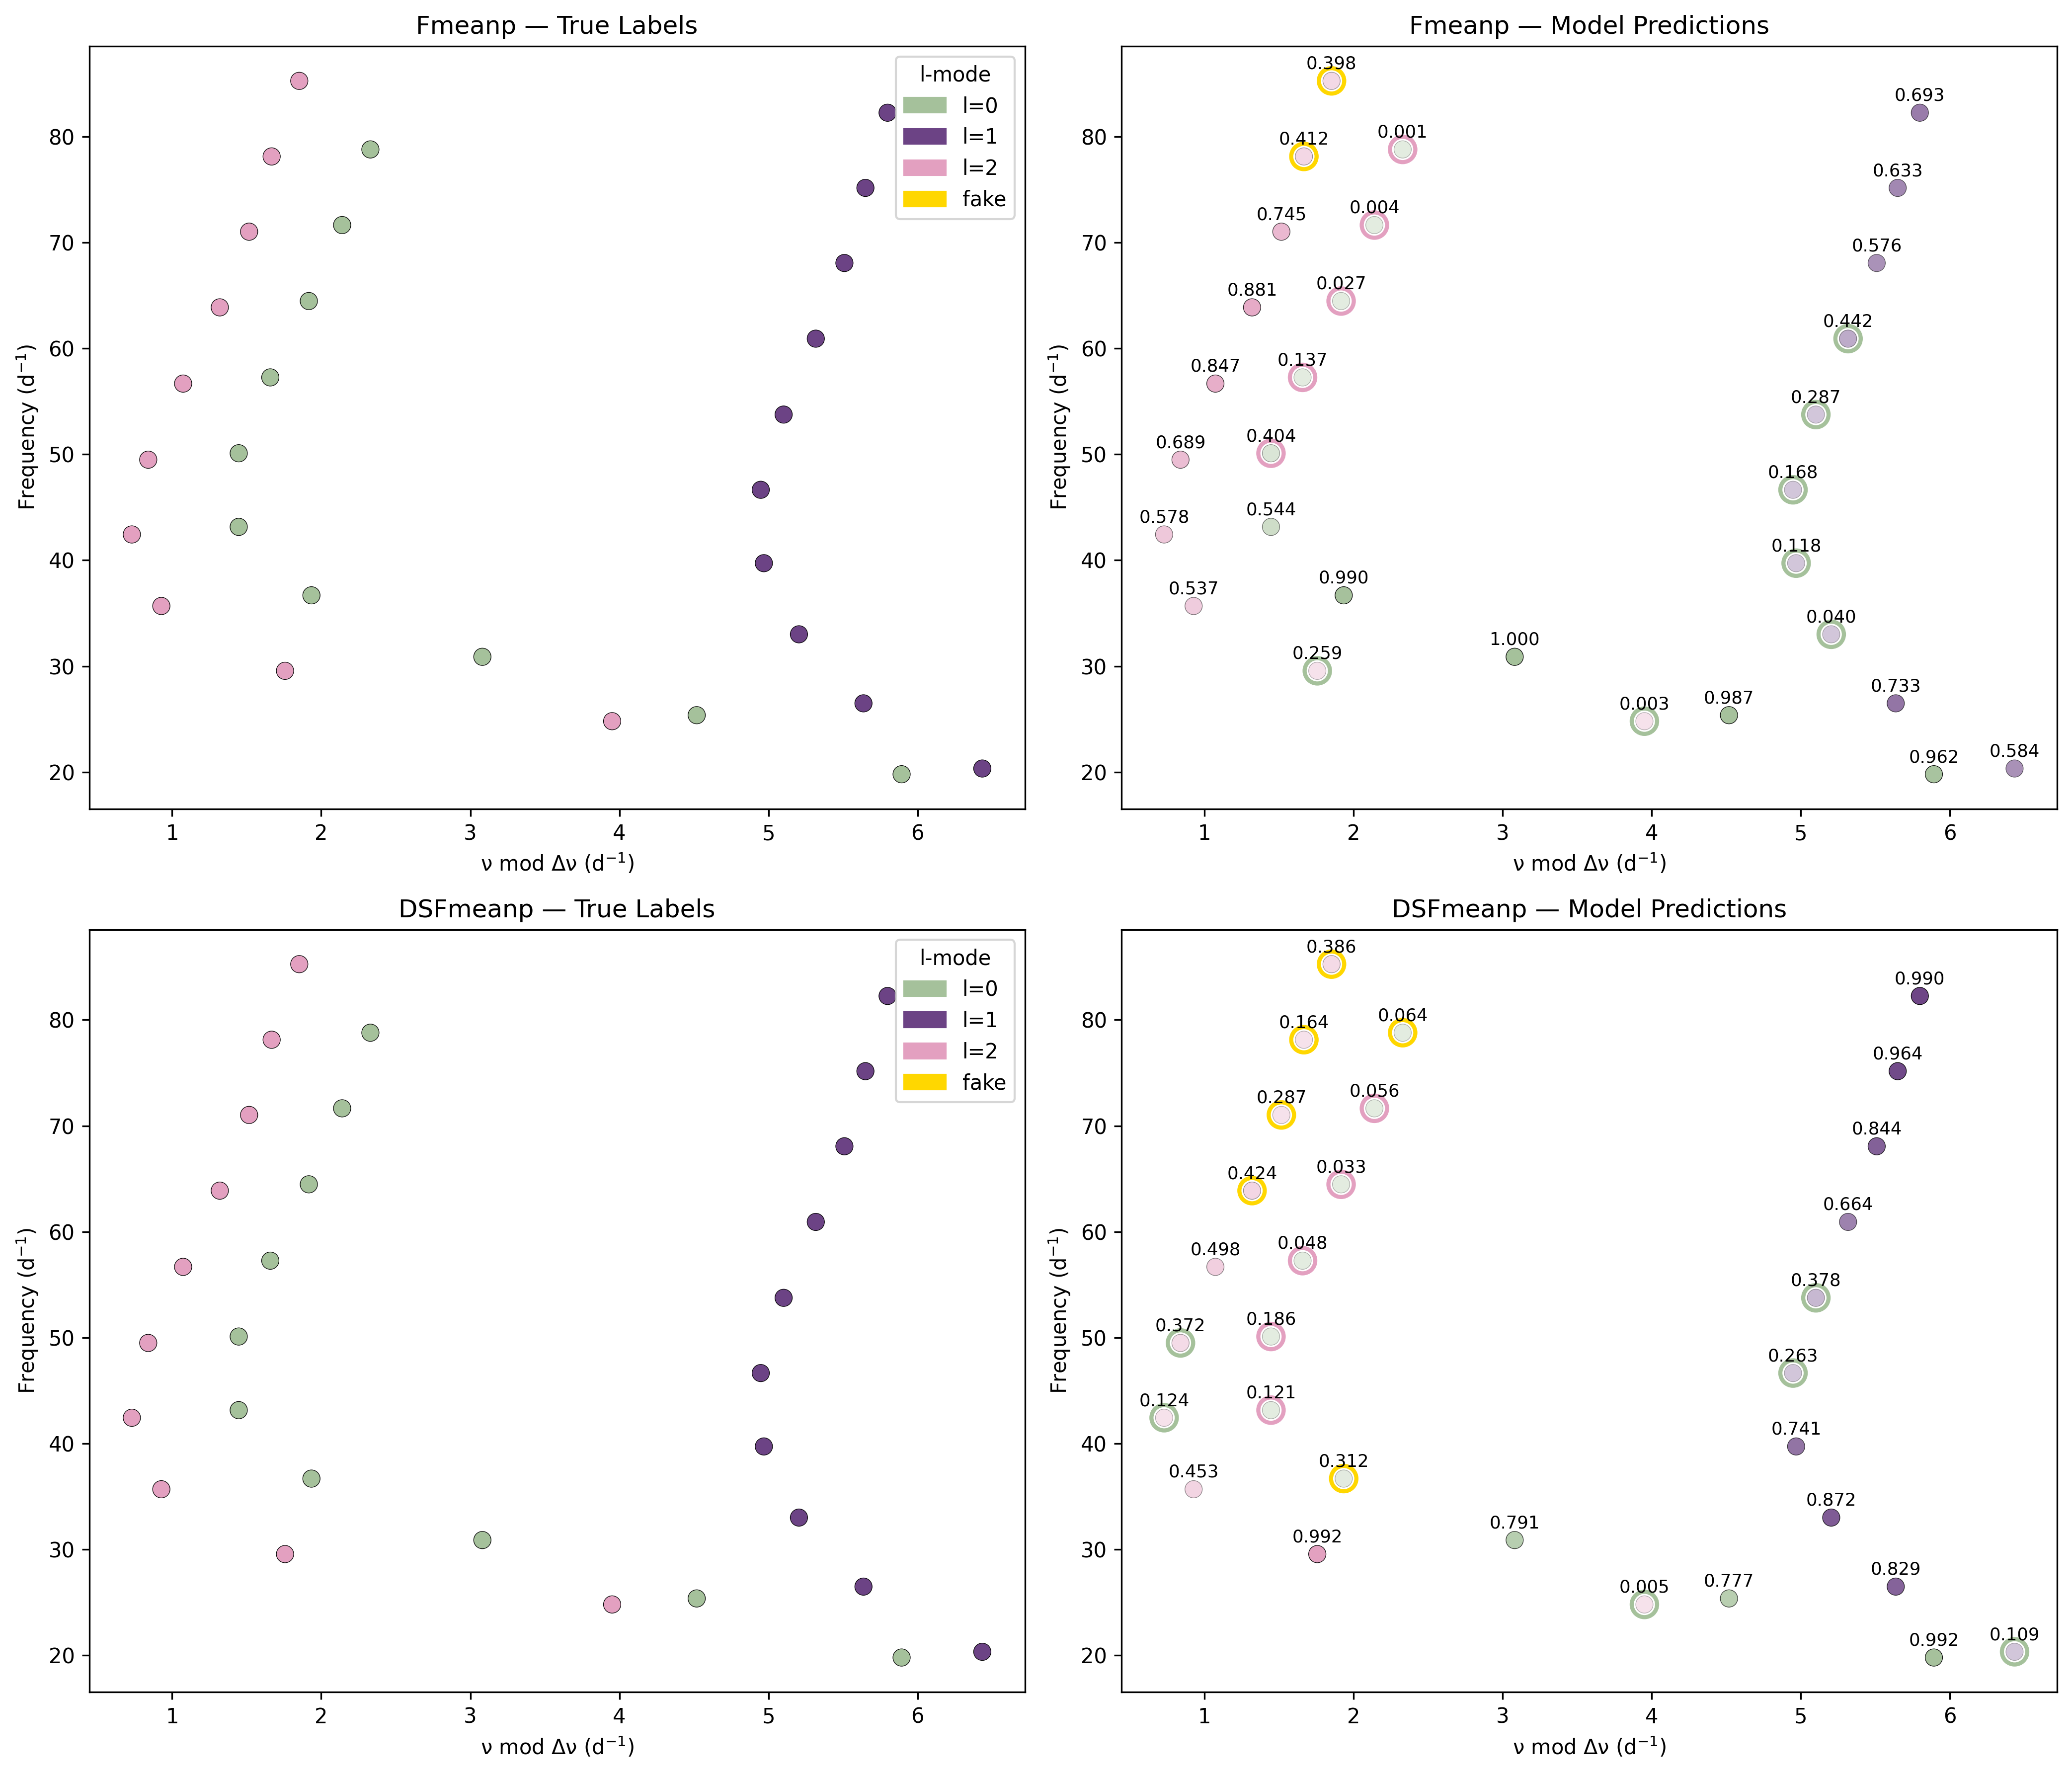

In [71]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import torch

# Config
REAL_CLASSES = [0, 1, 2]
FAKE_CLASS = 3  # matches your training
color_map = {0: '#a5c19b', 1: '#6c4385', 2: '#e3a0c0', FAKE_CLASS: 'gold'}
marker_size = 70

# Pick a random model/sample
num_models = X_test.shape[0]
model_idx = np.random.randint(0, num_models)
print(f"Selected model index: {model_idx}")

def prepare_plot_data(output_logits, y_test, X_test):
    # Extract logits and labels for selected model
    logits = output_logits[model_idx].detach().cpu().numpy() if torch.is_tensor(output_logits) else output_logits[model_idx]
    labels = y_test[model_idx]
    
    # Get frequencies
    freqs = X_test[model_idx, :, 0].numpy() if torch.is_tensor(X_test) else X_test[model_idx, :, 0]
    mod_nu = X_test[model_idx, :, 1].numpy() if torch.is_tensor(X_test) else X_test[model_idx, :, 1]

    # Mask valid points (all points are valid; fake points are part of labels)
    valid_mask = labels != -1
    labels = labels[valid_mask]
    logits = logits[:, valid_mask]
    freqs = freqs[valid_mask]
    mod_nu = mod_nu[valid_mask]

    # Probabilities
    logits = logits - np.max(logits, axis=0, keepdims=True)
    probs = np.exp(logits)
    probs /= probs.sum(axis=0, keepdims=True)

    # Predictions
    preds = np.argmax(probs, axis=0)
    
    # Display labels
    labels_display = np.array([l if l in REAL_CLASSES else FAKE_CLASS for l in labels], dtype=object)
    preds_display  = np.array([p if p in REAL_CLASSES else FAKE_CLASS for p in preds], dtype=object)
    
    # Probabilities of true labels (for alpha)
    probs_true_label = np.array([probs[l,i] if l in REAL_CLASSES else 1.0 for i,l in enumerate(labels)])

    # Colors
    colors_true = [color_map[l] for l in labels_display]
    edge_colors_pred = [color_map[p] for p in preds_display]

    # Misclassified points (excluding fake points)
    wrong_mask = (preds != labels) & (labels != FAKE_CLASS)
    wrong_freqs = freqs[wrong_mask]
    wrong_mod_nu = mod_nu[wrong_mask]
    wrong_edge_colors = np.array(edge_colors_pred)[wrong_mask]

    return freqs, mod_nu, labels_display, preds_display, probs_true_label, colors_true, wrong_freqs, wrong_mod_nu, wrong_edge_colors

# Prepare data for both outputs
fdata = prepare_plot_data(output_fmeanp, y_test_fmeanp, X_test)
ddata = prepare_plot_data(output_dsfmeanp, y_test_dsfmeanp, X_test)

# Plot 2x2
fig, axs = plt.subplots(2,2, figsize=(14,12), dpi=300)

# Top row: Fmeanp
axs[0,0].scatter(fdata[1], fdata[0], c=fdata[5], edgecolors='black', linewidths=0.3, s=marker_size)
axs[0,0].set_title("Fmeanp — True Labels")
axs[0,0].set_xlabel("ν mod Δν (d$^{-1}$)")
axs[0,0].set_ylabel("Frequency (d$^{-1}$)")

axs[0,1].scatter(fdata[1], fdata[0], c=fdata[5], alpha=np.clip(fdata[4], 0.3, 1.0), edgecolors='black', linewidths=0.3, s=marker_size)
axs[0,1].scatter(fdata[7], fdata[6], facecolors='none', edgecolors=fdata[8], linewidths=2.0, s=marker_size+80)
for i in range(len(fdata[0])):
    axs[0,1].text(fdata[1][i], fdata[0][i]+0.8, f"{fdata[4][i]:.3f}", fontsize=8.5, ha='center', va='bottom', color='black')
axs[0,1].set_title("Fmeanp — Model Predictions")
axs[0,1].set_xlabel("ν mod Δν (d$^{-1}$)")
axs[0,1].set_ylabel("Frequency (d$^{-1}$)")

# Bottom row: DSFmeanp
axs[1,0].scatter(ddata[1], ddata[0], c=ddata[5], edgecolors='black', linewidths=0.3, s=marker_size)
axs[1,0].set_title("DSFmeanp — True Labels")
axs[1,0].set_xlabel("ν mod Δν (d$^{-1}$)")
axs[1,0].set_ylabel("Frequency (d$^{-1}$)")

axs[1,1].scatter(ddata[1], ddata[0], c=ddata[5], alpha=np.clip(ddata[4], 0.3, 1.0), edgecolors='black', linewidths=0.3, s=marker_size)
axs[1,1].scatter(ddata[7], ddata[6], facecolors='none', edgecolors=ddata[8], linewidths=2.0, s=marker_size+80)
for i in range(len(ddata[0])):
    axs[1,1].text(ddata[1][i], ddata[0][i]+0.8, f"{ddata[4][i]:.3f}", fontsize=8.5, ha='center', va='bottom', color='black')
axs[1,1].set_title("DSFmeanp — Model Predictions")
axs[1,1].set_xlabel("ν mod Δν (d$^{-1}$)")
axs[1,1].set_ylabel("Frequency (d$^{-1}$)")

# Legend
legend_elements = [
    mpatches.Patch(color=color_map[0], label='l=0'),
    mpatches.Patch(color=color_map[1], label='l=1'),
    mpatches.Patch(color=color_map[2], label='l=2'),
    mpatches.Patch(color=color_map[FAKE_CLASS], label='fake')
]
axs[0,0].legend(handles=legend_elements, title="l-mode", loc="upper right")
axs[1,0].legend(handles=legend_elements, title="l-mode", loc="upper right")

plt.tight_layout()
plt.show()

## Now trying the mode identification

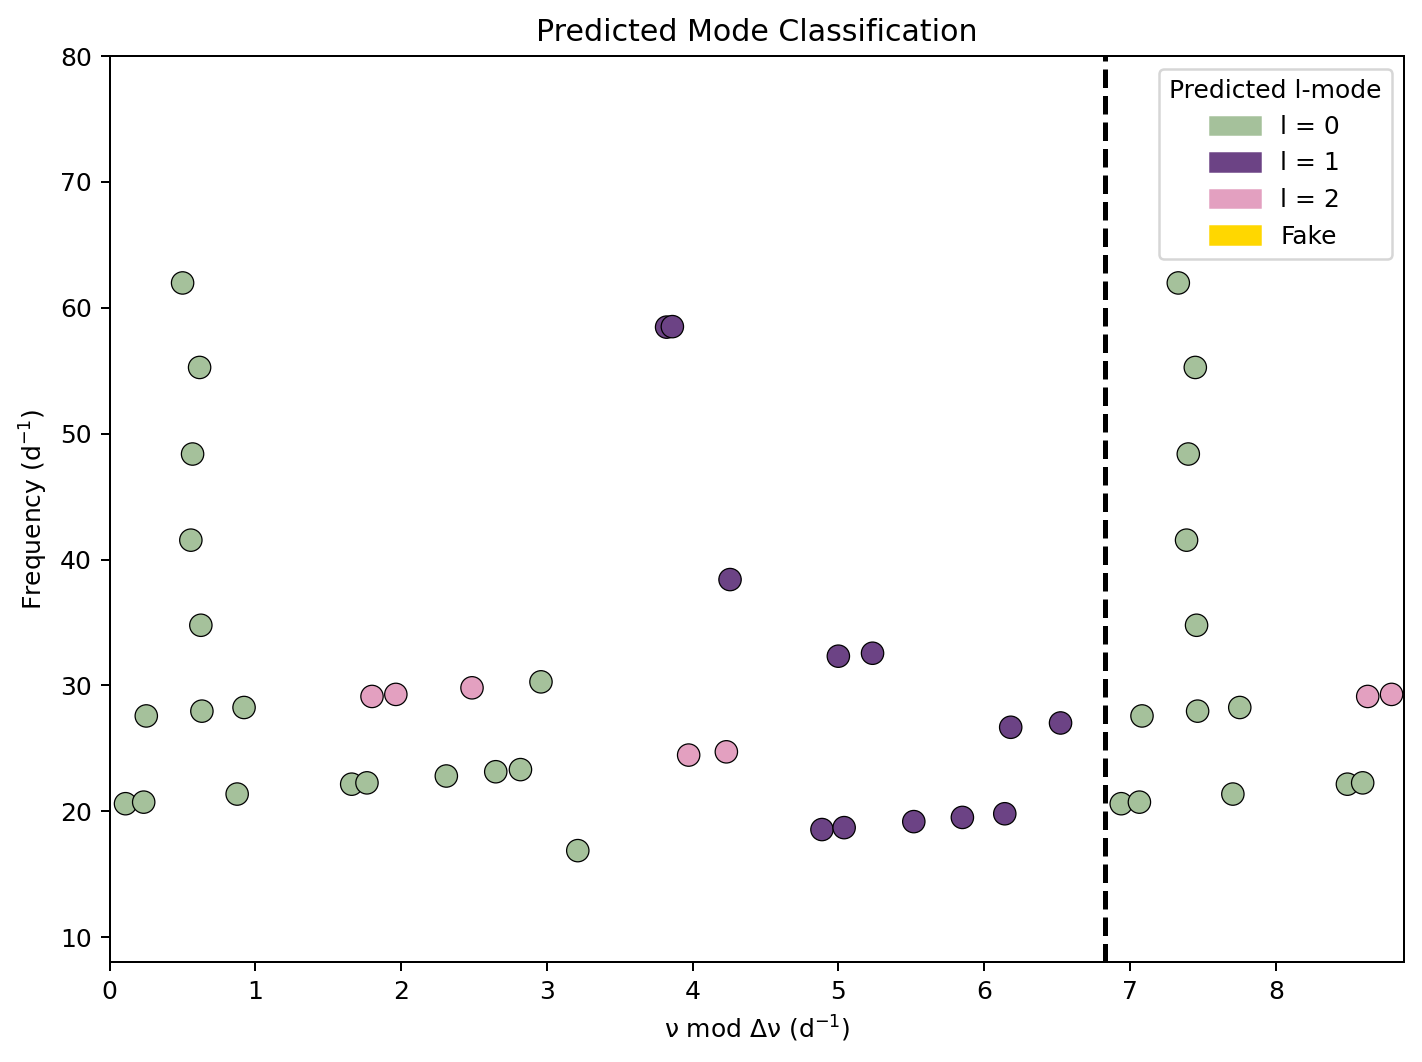

In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Frequencies to identify (Hz/d)
frequencies = np.array([
    21.36513, 27.95328, 34.77609, 41.53747, 48.37933, 55.25743, 61.97086,
    16.87165, 32.55347, 38.40601, 58.46084, 28.24243, 27.01307, 20.59936,
    18.54655, 18.69868, 19.17648, 19.50970, 19.80056, 20.72404, 22.15081,
    22.25558, 22.79990, 23.13894, 23.30843, 24.46210, 24.72073, 26.67124,
    27.57177, 29.12013, 29.28361, 29.80605, 30.27912, 32.31897, 58.50036
])

# Large separation (Δν)
delta_nu = 6.83

# Compute ν mod Δν and prepare input
nu_mod_delta_nu = np.mod(frequencies, delta_nu)
X_hd = torch.tensor(
    np.stack([frequencies, nu_mod_delta_nu], axis=1),
    dtype=torch.float32
).unsqueeze(0)  # Shape [1, N_points, 2]

# Model definition (must match training)
class PointNet(nn.Module):
    def __init__(self, num_classes=4, point_dimension=2, aggregator="mean"):
        super(PointNet, self).__init__()

        a = 3
        nfeat = 64 
        self.conv_1_a = nn.Conv1d(1, nfeat, kernel_size=a, padding=2)
        self.conv_1_b = nn.Conv1d(1, nfeat, kernel_size=a, padding=2)
        self.conv_2 = nn.Conv1d(nfeat, nfeat, kernel_size=a, padding=2)
        self.bn_1 = nn.BatchNorm1d(nfeat)
        self.bn_2 = nn.BatchNorm1d(nfeat)

        # aggregator type: "max" or "mean"
        self.aggregator = aggregator

    def forward(self, x, plot=False):
        batch_size, num_points, _ = x.shape
        x_freq = x[:, :, 0].unsqueeze(1)
        x_modnu = x[:, :, 1].unsqueeze(1)
        x_freq = F.pad(x_freq, (1, 1), mode='replicate')
        x_modnu = F.pad(x_modnu, (1, 1), mode='circular')
        x_freq_feat = self.conv_1_a(x_freq)
        x_modnu_feat = self.conv_1_b(x_modnu)
        x = x_freq_feat + x_modnu_feat
        x = F.relu(self.bn_1(x))
        x = F.relu(self.bn_2(self.conv_2(x)))

        if self.aggregator == "max":
            x = F.max_pool1d(x, kernel_size=num_points)
        elif self.aggregator == "mean":
            x = F.avg_pool1d(x, kernel_size=num_points)
        else:
            raise ValueError(f"Unknown aggregator type: {self.aggregator}")

        x = x.view(batch_size, -1)
        return x

class SegmentationPointNet(nn.Module):
    def __init__(self, num_classes=4, point_dimension=2, aggregator="mean"):
        super(SegmentationPointNet, self).__init__()
        self.base_pointnet = PointNet(
            num_classes=num_classes, point_dimension=point_dimension, aggregator=aggregator)
        nhidden = 64
        nfeat = 64 
        self.fc_1 = nn.Linear(nfeat + 2, nhidden)
        self.fc_2 = nn.Linear(nhidden, num_classes)

    def forward(self, x):
        global_features = self.base_pointnet(x)
        global_features = global_features.unsqueeze(1).repeat(1, x.shape[1], 1)
        x = torch.cat((x, global_features), dim=2)
        x = F.relu(self.fc_1(x))
        return F.log_softmax(self.fc_2(x), dim=2)   

# Load trained weights
#model_path = "segmentation_pointnet_fmeanp.pth" 
model_path = "segmentation_pointnet_dsfmeanp.pth" 
model = SegmentationPointNet()
model.load_state_dict(torch.load(model_path, map_location="cpu"))
model.eval()

# Predict
with torch.no_grad():
    logits_hd = model(X_hd)           # Shape [1, N_points, 4]
    probs_hd = torch.exp(logits_hd)[0].numpy()
    preds_hd = np.argmax(probs_hd, axis=1)

# -------------------------------
# Visualization
color_map = {0: '#a5c19b', 1: '#6c4385', 2: '#e3a0c0', 3: 'gold'}
colors_pred = [color_map[int(p)] for p in preds_hd]
legend_elements = [
    mpatches.Patch(color=color_map[0], label="l = 0"),
    mpatches.Patch(color=color_map[1], label="l = 1"),
    mpatches.Patch(color=color_map[2], label="l = 2"),
    mpatches.Patch(color=color_map[3], label="Fake"),
]

fig, ax = plt.subplots(figsize=(8, 6), dpi=180)
ax.scatter(nu_mod_delta_nu, frequencies, c=colors_pred, edgecolors="black", linewidths=0.5, s=80)
ax.scatter(nu_mod_delta_nu + delta_nu, frequencies, c=colors_pred, edgecolors="black", linewidths=0.5, s=80)
ax.axvline(delta_nu, color="black", linestyle="--", linewidth=2)
ax.set_xlim(0, delta_nu * 1.3)
ax.set_ylim(8, 80)
ax.legend(handles=legend_elements, title="Predicted l-mode", loc="upper right")
ax.set_title("Predicted Mode Classification", fontsize=12)
ax.set_xlabel("ν mod Δν (d$^{-1}$)")
ax.set_ylabel("Frequency (d$^{-1}$)")
plt.tight_layout()
plt.show()


## Confusion matrix

Original shapes: (15332, 30) (15332, 30)


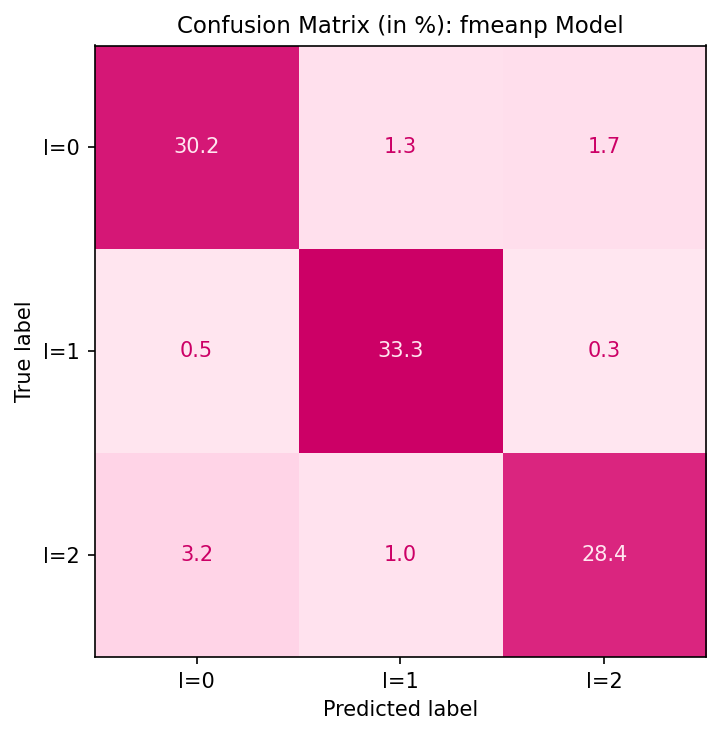

In [31]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
import numpy as np
import pickle

# Load files
with open("test_predictions_fmeanp.pkl", "rb") as f:
    log_preds = pickle.load(f)   # likely [B, N, C]
with open("test_targets_fmeanp.pkl", "rb") as f:
    true_labels = pickle.load(f) # likely [B, N]

print("Original shapes:", log_preds.shape, true_labels.shape)

probs = np.exp(log_preds)
pred_labels = log_preds.astype(int) 
true_flat = true_labels.flatten()
pred_flat = pred_labels.flatten()

cm = confusion_matrix(true_flat, pred_flat, labels=[0, 1, 2])
cm_percent = cm / cm.sum() * 100

pink_cmap = LinearSegmentedColormap.from_list("custom_pink", ["#ffe6f0", "#ff80bf", "#cc0066"])

fig, ax = plt.subplots(figsize=(6, 5), dpi=150)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_percent, display_labels=["l=0", "l=1", "l=2"])
disp.plot(ax=ax, cmap=pink_cmap, colorbar=False, values_format=".1f")

plt.title("Confusion Matrix (in %): fmeanp Model", fontsize=11)
plt.savefig("confusionmatrix_fmeanp.jpg", bbox_inches="tight", pad_inches=0.3, transparent=True, dpi=300)
plt.tight_layout()
plt.show()

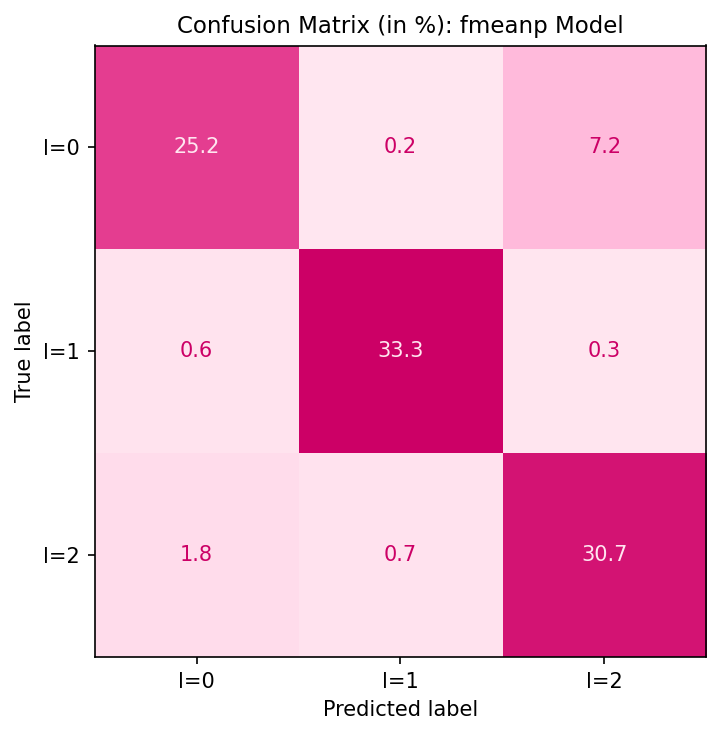

In [32]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
import numpy as np
import pickle

with open("test_predictions_dsfmeanp.pkl", "rb") as f:
    log_preds = pickle.load(f)   # likely [B, N, C]
with open("test_targets_dsfmeanp.pkl", "rb") as f:
    true_labels = pickle.load(f) # likely [B, N]

# print("Original shapes:", log_preds.shape, true_labels.shape)
probs = np.exp(log_preds)
pred_labels = log_preds.astype(int) 
true_flat = true_labels.flatten()
pred_flat = pred_labels.flatten()

cm = confusion_matrix(true_flat, pred_flat, labels=[0, 1, 2])
cm_percent = cm / cm.sum() * 100

pink_cmap = LinearSegmentedColormap.from_list("custom_pink", ["#ffe6f0", "#ff80bf", "#cc0066"])

fig, ax = plt.subplots(figsize=(6, 5), dpi=150)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_percent, display_labels=["l=0", "l=1", "l=2"])
disp.plot(ax=ax, cmap=pink_cmap, colorbar=False, values_format=".1f")

plt.title("Confusion Matrix (in %): fmeanp Model", fontsize=11)
plt.savefig("confusionmatrix_dsfmeanp.jpg", bbox_inches="tight", pad_inches=0.3, transparent=True, dpi=300)
plt.tight_layout()
plt.show()